In [1]:
import numpy as np
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model
import os
import tensorflow as tf
import time
import datetime
import csv
import sys
sys.path.append(os.pardir)
from createdatas import createdata
from scipy.optimize import curve_fit    # フィッティング用
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' #意味はわからん

import os #システム操作系
from pathlib import Path #ファイル操作系

import matplotlib as mpl
import matplotlib.pyplot as plt

NOISE = '10+30'
date = str(datetime.date.today())
print(date)

Using TensorFlow backend.


2020-10-30


In [2]:
# このファイルの存在するフォルダの絶対パスを取得
dir_name = str(Path().resolve())
print('このファイルの存在するフォルダ：', dir_name)

# 保存先フォルダのパス作成
save_folder = os.path.join(dir_name, f'learning{NOISE}%')
print('保存フォルダ：', save_folder)

# 保存先フォルダの作成(既に存在する場合は無視される)
os.makedirs(save_folder, exist_ok=True)

このファイルの存在するフォルダ： /Users/nagaiyuma/Documents/myprogram
保存フォルダ： /Users/nagaiyuma/Documents/myprogram/learning10+30%


In [3]:
train_num = 5000 #訓練データの数
test_num = 500 #テストデータの数
data_size = 100 #配列の大きさ

In [4]:
x10_train = np.zeros((train_num,data_size))
y10_train = np.zeros((train_num,data_size))
t10_train = np.zeros((train_num, 3))
t10y_train = np.zeros((train_num, 3))
x10_test = np.zeros((test_num,data_size))
y10_test = np.zeros((test_num,data_size))
t10_test = np.zeros((test_num, 3))
t10y = np.zeros((test_num, 3))
NOISE = 10
#訓練データの生成
fit_param_x = np.zeros((train_num, 4))
fit_param_y = np.zeros((train_num, 4))
createdata(train_num, NOISE, data_size, x10_train, y10_train, t10_train, t10y_train, fit_param_x, fit_param_y)
#テストデータの生成
fit_param_x = np.zeros((test_num, 4))
fit_param_y = np.zeros((test_num, 4))
createdata(test_num, NOISE, data_size, x10_test, y10_test, t10_test, t10y, fit_param_x, fit_param_y)

NOISE = 30
x30_train = np.zeros((train_num,data_size))
y30_train = np.zeros((train_num,data_size))
t30_train = np.zeros((train_num, 3))
t30y_train = np.zeros((train_num, 3))
x30_test = np.zeros((test_num,data_size))
y30_test = np.zeros((test_num,data_size))
t30_test = np.zeros((test_num, 3))
t30y = np.zeros((test_num, 3))
#訓練データの生成
fit_param_x = np.zeros((train_num, 4))
fit_param_y = np.zeros((train_num, 4))
createdata(train_num, NOISE, data_size, x30_train, y30_train, t30_train, t30y_train, fit_param_x, fit_param_y)
#テストデータの生成
fit_param_x = np.zeros((test_num, 4))
fit_param_y = np.zeros((test_num, 4))
createdata(test_num, NOISE, data_size, x30_test, y30_test, t30_test, t30y, fit_param_x, fit_param_y)

KeyboardInterrupt: 

In [ ]:
train_num = 10000 #訓練データの数
test_num = 1000 #テストデータの数
x_train = np.array((x10_train, x30_train)).reshape([train_num, data_size])
t_train = np.array((t10_train, t30_train)).reshape([train_num, 3])
x_test = np.array((x10_test, x30_test)).reshape([test_num, data_size])
t_test = np.array((t10_test, t30_test)).reshape([test_num, 3])

In [8]:
#訓練データ,テストデータの保存
save_x_train = "/Users/nagaiyuma/Desktop/maindata/"+date+"x_train10+30.csv"
save_t_train = "/Users/nagaiyuma/Desktop/maindata/"+date+"t_train10+30.csv"
save_x_test = "/Users/nagaiyuma/Desktop/maindata/"+date+"x_test10+30.csv"
save_t_test = "/Users/nagaiyuma/Desktop/maindata/"+date+"t_test10+30.csv"

with open(save_x_train,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_train)
with open(save_t_train,'w') as f:
    writer = csv.writer(f)
    writer.writerows(t_train)
with open(save_x_test,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_test)
with open(save_t_test,'w') as f:
    writer = csv.writer(f)
    writer.writerows(t_test)

In [2]:
#過去の訓練データの読込
data_py_path = "/Users/nagaiyuma/Desktop/maindata/201030/2020-10-30"
with open(data_py_path + "x_train10+30.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_train = np.array([row for row in reader])
    
with open(data_py_path + "x_test10+30.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_test = np.array([row for row in reader])
    
with open(data_py_path + "t_train10+30.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    t_train = np.array([row for row in reader])
    
with open(data_py_path + "t_test10+30.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    t_test = np.array([row for row in reader])

In [3]:
#まともなCNN3の実装
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(10, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(100, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(3, activation='relu', kernel_initializer="he_normal"))

model.summary()

callbacks = [keras.callbacks.TensorBoard(log_dir='./logs',
                            histogram_freq=1, 
                            batch_size=batch_size, 
                            write_graph=True, 
                            write_grads=True)]

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t),
 callbacks=callbacks)

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/parameters/"+date+"-10+30cnn3.h5"
model.save(save_model_path)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)             

現在時刻： 2020-10-30 15:20:53.035969
保存ファイル名： 2020-10-30_15-20_cnn3_noise10_N1000.svg
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/learning10+30%/2020-10-30_15-20_cnn3_noise10_N1000.svg


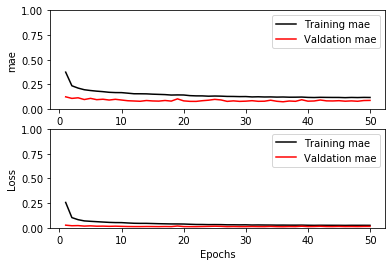


保存完了！


In [19]:
N = 1000
NOISE = 10
dt_now = datetime.datetime.now()
print('現在時刻：', dt_now)
#損失関数とmaeの推移
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_cnn3_noise{NOISE}_N{N}.svg'
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 1.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.savefig(save_file, format="svg", bbox_inches="tight")
plt.show()
plt.close()
print('\n保存完了！')

In [12]:
abs_error = abs(np.array(model.predict(test_x).T[1].flatten()- t_test.T[1].flatten()))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
error = "平均絶対誤差: %f ± %f" % (ave_abs, std_abs)
print(error)

平均絶対誤差: 0.191790 ± 0.130753


In [13]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

hist_json_file = f'/Users/nagaiyuma/Desktop/parameters/{date}history10+30_3.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [14]:
t_train = t_train.T[1].flatten()
t_test = t_test.T[1].flatten()

#まともなCNNの実装
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(10, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(100, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu', kernel_initializer="he_normal"))

model.summary()

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/parameters/"+date+"-10+30cnn1.h5"
model.save(save_model_path)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

現在時刻： 2020-10-30 15:20:31.077231
保存ファイル名： 2020-10-30_15-20_ccn1_noise10_N1000.svg
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/learning10+30%/2020-10-30_15-20_ccn1_noise10_N1000.svg


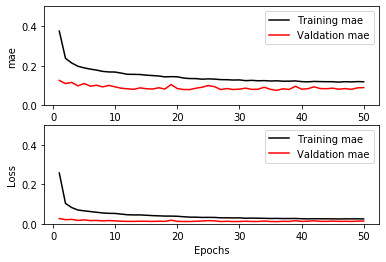

In [16]:
N = 1000
NOISE = 10
dt_now = datetime.datetime.now()
print('現在時刻：', dt_now)
#損失関数とmaeの推移
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_ccn1_noise{NOISE}_N{N}.svg'
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 0.5)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 0.5)
plt.savefig(save_file, format="svg", bbox_inches="tight")
plt.show()
plt.close()

In [17]:
abs_error = abs(np.array(model.predict(test_x).flatten()- t_test))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
error = "平均絶対誤差: %f ± %f" % (ave_abs, std_abs)
print(error)

平均絶対誤差: 0.088923 ± 0.077842


In [18]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

hist_json_file = 'history10_1.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)